### 1: Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ValueWarning

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GroupNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)


import sys
print(sys.executable)


b:\Dublin City University\Practicum\Proj\venv_311\Scripts\python.exe


### 2: Load and Explore Dataset

In [2]:
multimodal = pd.read_csv("train_dataset.csv", parse_dates=["Date"])
multimodal.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Log_Returns,Volatility_Log_10,cl-op,...,total_question_intent,total_action_intent,sentiment_minus_uncertainty,sentiment_minus_fear,sentiment_minus_action,sentiment_minus_urgency,sentiment_minus_prediction,Next_3_Close,Next_7_Close,Next_Close
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.004085,0.168436,302.230468,...,0.545455,0.625,0.238850,-0.094484,-1.011150,-0.261150,-0.094484,NaN,NaN,NaN
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,0.011943,0.192941,52.679687,...,0.363636,0.375,-0.513462,-0.180129,-0.596796,-0.346796,0.153204,NaN,NaN,11734.320312
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.009451,0.188543,-139.230468,...,0.545455,0.375,-0.666667,0.000000,-0.750000,-0.500000,0.000000,NaN,NaN,11782.349609
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.007168,0.189348,-99.849609,...,0.454545,0.625,0.000000,0.000000,-1.250000,0.000000,-0.333333,11734.320312,NaN,11642.469727
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,-0.003778,0.208874,83.859376,...,0.454545,0.375,-0.536607,-0.536607,-0.619940,-0.869940,-0.869940,11782.349609,NaN,11532.959961


In [3]:
multimodal.shape

(1591, 56)

In [4]:
missing_values = multimodal.isnull().sum()
print("\nMissing values per column:")
missing_values[missing_values > 0]


Missing values per column:


Next_3_Close    3
Next_7_Close    7
Next_Close      1
dtype: int64

In [5]:
multimodal.describe()
multimodal.dtypes

Date                           datetime64[ns]
Open                                  float64
High                                  float64
Low                                   float64
Close                                 float64
Volume                                  int64
Adj Close                             float64
Log_Returns                           float64
Volatility_Log_10                     float64
cl-op                                 float64
hi-lo                                 float64
Label                                   int64
vader_news_sentiment                  float64
FinBERT_news_sentiment                float64
Smart_news_sentiment                  float64
news_buying_intent                    float64
news_selling_intent                   float64
news_uncertainty_intent               float64
news_urgency_intent                   float64
news_prediction_intent                float64
news_fear_intent                      float64
news_greed_intent                 

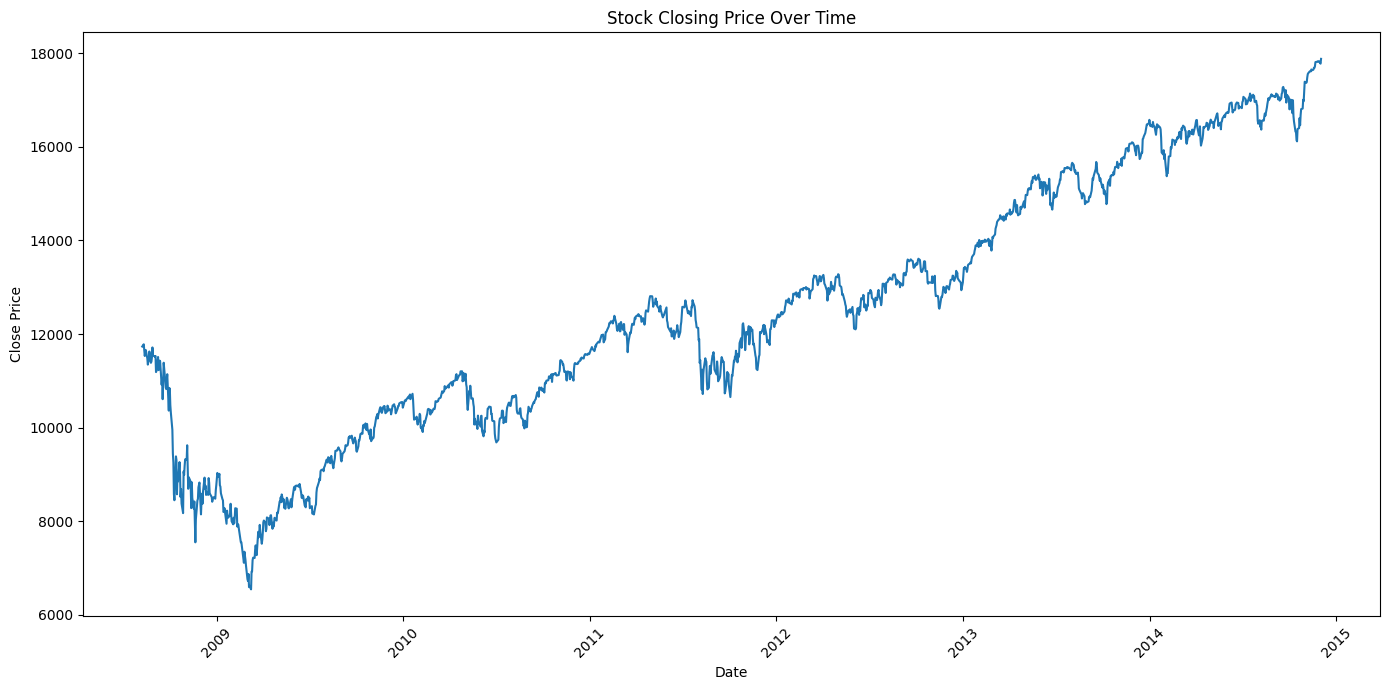

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(multimodal['Date']), multimodal['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3: Data Preprocessing

In [7]:
# Drop top 10 (rolling NaNs) and bottom 7 (from shift(-7))
multimodal_modelling = multimodal.iloc[10:-7].copy()

# Optional: reset index
# multimodal_modelling.reset_index(drop=True, inplace=True)

# Sanity check
print(f"Shape: {multimodal_modelling.shape}")
print(multimodal_modelling.isnull().sum())

Shape: (1574, 56)
Date                           0
Open                           0
High                           0
Low                            0
Close                          0
Volume                         0
Adj Close                      0
Log_Returns                    0
Volatility_Log_10              0
cl-op                          0
hi-lo                          0
Label                          0
vader_news_sentiment           0
FinBERT_news_sentiment         0
Smart_news_sentiment           0
news_buying_intent             0
news_selling_intent            0
news_uncertainty_intent        0
news_urgency_intent            0
news_prediction_intent         0
news_fear_intent               0
news_greed_intent              0
news_question_intent           0
news_action_intent             0
vader_reddit_sentiment         0
FinBERT_reddit_sentiment       0
Smart_reddit_sentiment         0
reddit_buying_intent           0
reddit_selling_intent          0
reddit_uncertainty_intent

In [8]:
df_targets = multimodal_modelling[["Date", "Target", "Label", "Close", "Next_Close", "Next_3_Close", "Next_7_Close"]].copy()

df_arima = multimodal_modelling[["Date", "Close"]].copy()
df_arima.set_index("Date", inplace=True)

drop_cols_lstm = ["Date", "Label", "Target", "Next_Close", "Next_3_Close", "Next_7_Close"]
df_lstm = multimodal_modelling.drop(columns=drop_cols_lstm).copy()

drop_cols_tcn = ["Date", "Label", "Target", "Next_Close", "Next_3_Close", "Next_7_Close"]
df_tcn = multimodal_modelling.drop(columns=drop_cols_tcn).copy()

In [9]:
df_tcn.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Log_Returns',
       'Volatility_Log_10', 'cl-op', 'hi-lo', 'vader_news_sentiment',
       'FinBERT_news_sentiment', 'Smart_news_sentiment', 'news_buying_intent',
       'news_selling_intent', 'news_uncertainty_intent', 'news_urgency_intent',
       'news_prediction_intent', 'news_fear_intent', 'news_greed_intent',
       'news_question_intent', 'news_action_intent', 'vader_reddit_sentiment',
       'FinBERT_reddit_sentiment', 'Smart_reddit_sentiment',
       'reddit_buying_intent', 'reddit_selling_intent',
       'reddit_uncertainty_intent', 'reddit_urgency_intent',
       'reddit_prediction_intent', 'reddit_fear_intent', 'reddit_greed_intent',
       'reddit_question_intent', 'reddit_action_intent', 'pct_change',
       'finbert_final_sentiment', 'total_buying_intent',
       'total_selling_intent', 'total_uncertainty_intent',
       'total_urgency_intent', 'total_prediction_intent', 'total_fear_intent',
       'total_gre

### 4: Time Series Stationarity Analysis for ARIMA

In [10]:
df_arima.head()

,Close
Date,
2008-08-22,11628.059570
2008-08-25,11386.250000
2008-08-26,11412.870117
2008-08-27,11502.509766
2008-08-28,11715.179688


In [11]:
result = adfuller(df_arima["Close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.3291225925952715
p-value: 0.9786418627908441


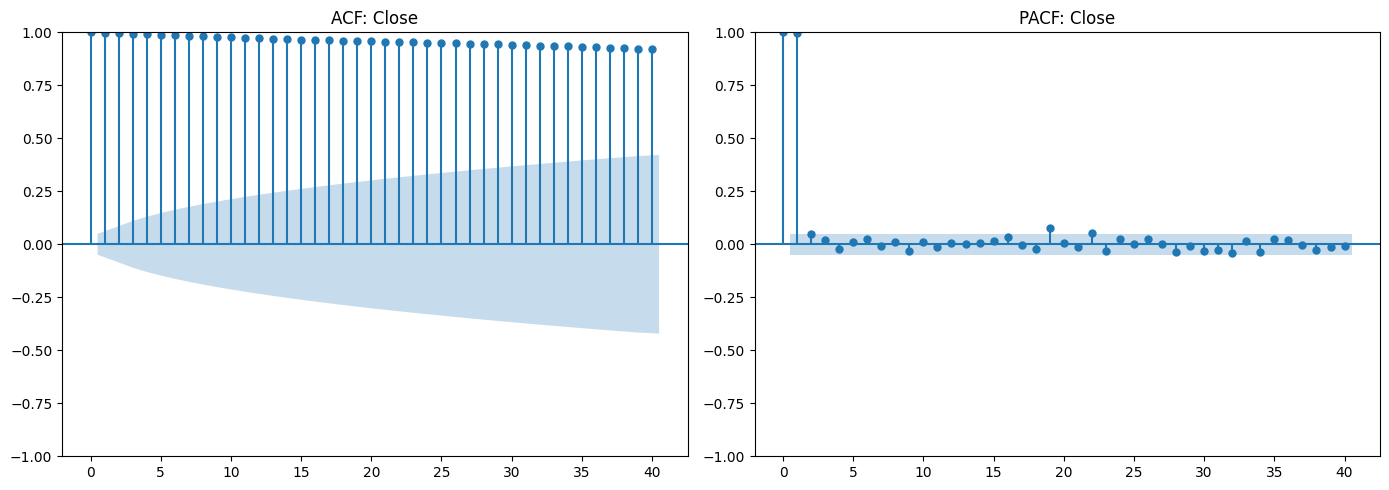

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(multimodal_modelling["Close"], lags=40, ax=plt.gca())
plt.title("ACF: Close")

plt.subplot(1, 2, 2)
plot_pacf(multimodal_modelling["Close"], lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF: Close")

plt.tight_layout()
plt.show()

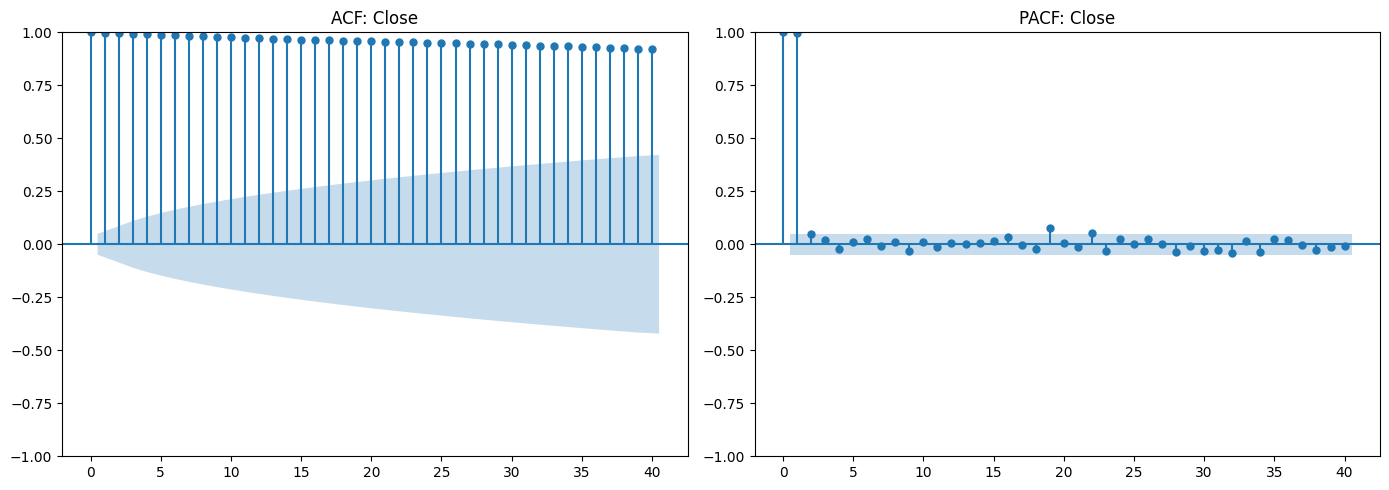

In [13]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(df_arima["Close"], lags=40, ax=plt.gca())
plt.title("ACF: Close")

plt.subplot(1, 2, 2)
plot_pacf(df_arima["Close"], lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF: Close")

plt.tight_layout()
plt.show()


📈 Training ARIMA for Next_Close with order (1, 0, 1)
AIC: 19963.84, BIC: 19985.28
Forecast tail:
 1574    17711.264889
dtype: float64
True tail:
 [17685.730469]
Next_Close — R²: nan, RMSE: 25.53, MAE: 25.53


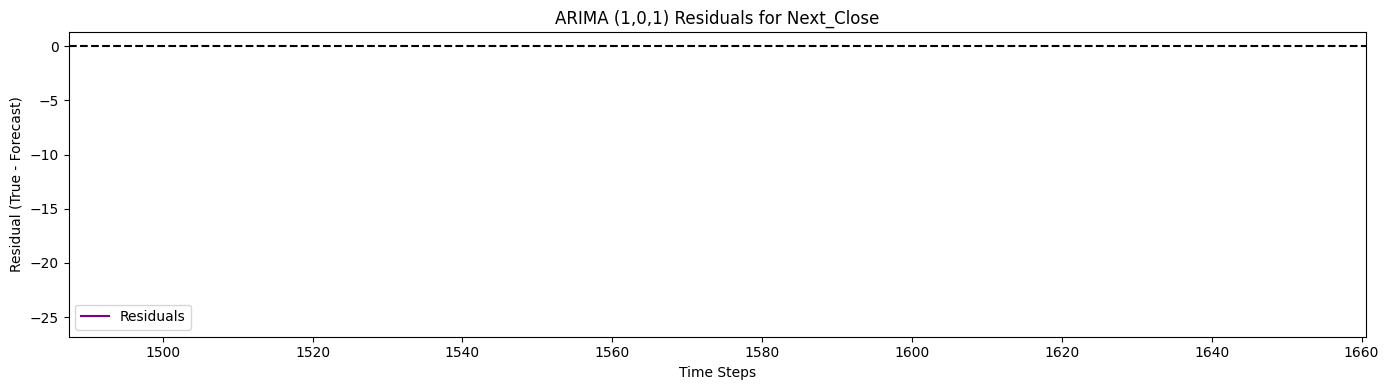


📈 Training ARIMA for Next_3_Close with order (1, 0, 1)
AIC: 19963.84, BIC: 19985.28
Forecast tail:
 1574    17711.264889
1575    17707.519776
1576    17703.777323
Name: predicted_mean, dtype: float64
True tail:
 [17652.789062 17634.740234 17647.75    ]
Next_3_Close — R²: -67.3428, RMSE: 62.86, MAE: 62.43


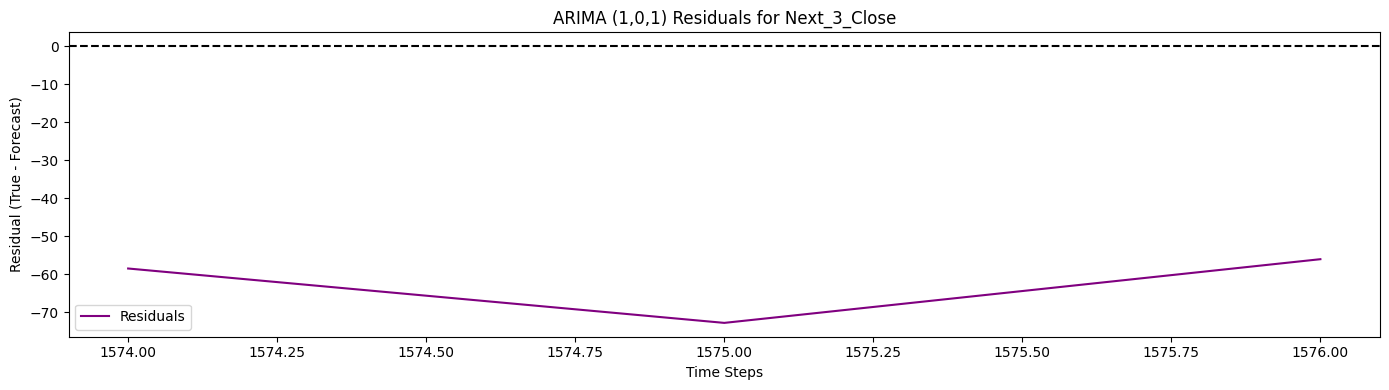


📈 Training ARIMA for Next_7_Close with order (1, 0, 1)
AIC: 19963.84, BIC: 19985.28
Forecast tail:
 1574    17711.264889
1575    17707.519776
1576    17703.777323
1577    17700.037529
1578    17696.300392
1579    17692.565909
1580    17688.834079
Name: predicted_mean, dtype: float64
True tail:
 [17366.240234 17383.839844 17484.529297 17554.470703 17573.929688
 17613.740234 17614.900391]
Next_7_Close — R²: -3.9192, RMSE: 213.72, MAE: 186.95


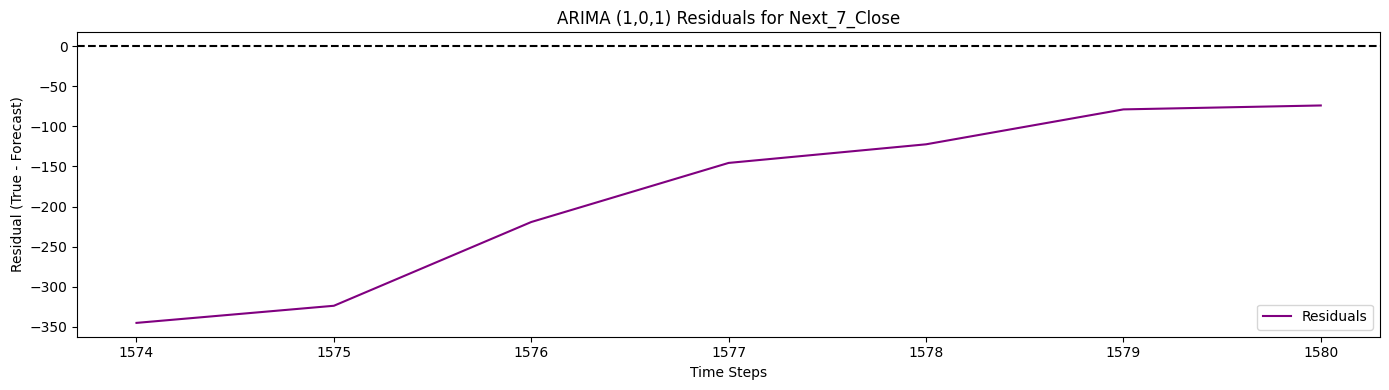

In [ ]:
def train_arima_forecast_n(df_arima, df_targets, target_col='Next_Close', order=(1, 1, 1)):
    print(f"\n📈 Training ARIMA for {target_col} with order {order}")

    if target_col == 'Next_Close':
        shift_n = 1
    elif 'Next_' in target_col and '_Close' in target_col:
        shift_n = int(target_col.replace('Next_', '').replace('_Close', ''))
    else:
        raise ValueError(f"Invalid target_col: {target_col}")

    model = ARIMA(df_arima['Close'], order=order)
    model_fit = model.fit()

    start_idx = len(df_arima)
    forecast = model_fit.forecast(steps=shift_n)

    true = df_targets[target_col].values[start_idx : start_idx + shift_n]

    # Save info
    print(f"AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")
    print("Forecast tail:\n", forecast)
    print("True tail:\n", true)

    r2 = r2_score(true, forecast)
    rmse = np.sqrt(mean_squared_error(true, forecast))
    mae = mean_absolute_error(true, forecast)
    print(f"{target_col} — R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    return model_fit, forecast, true


def plot_arima_results(df_arima, forecast, true, target_col='Next_Close'):
    plt.figure(figsize=(14, 7))
    plt.plot(df_arima.index, df_arima["Close"], label='Actual Close', color='blue')
    plt.plot(df_arima.index[:len(forecast)], forecast, label=f'ARIMA Forecast ({target_col})', color='orange')
    plt.scatter(df_arima.index[:len(true)], true, label=f'True {target_col}', color='red', s=10)
    plt.title(f'ARIMA (1,0,1) Forecast vs Actual for {target_col}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for target in ['Next_Close', 'Next_3_Close', 'Next_7_Close']:
    model, forecast, true = train_arima_forecast_n(df_arima, df_targets, target_col=target, order=(1,0,1))

    # Plot residuals
    residuals = true - forecast
    plt.figure(figsize=(14, 4))
    plt.plot(residuals, label="Residuals", color='purple')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f'ARIMA (1,0,1) Residuals for {target}')
    plt.xlabel('Time Steps')
    plt.ylabel('Residual (True - Forecast)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## LSTM Model

In [ ]:
df_lstm.columns

In [ ]:
def train_lstm(df_lstm, df_targets, target_col='Next_Close', window_size=60, epochs=50, batch_size=32, stacked=False):
    print(f"\n🧠 Training LSTM ({'Stacked' if stacked else 'Single'}) model for target: {target_col}")

    # Scale features and target
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(df_lstm)
    y_scaled = y_scaler.fit_transform(df_targets[[target_col]])

    # Create sequences
    X_seq, y_seq = [], []
    for i in range(window_size, len(X_scaled)):
        X_seq.append(X_scaled[i-window_size:i])
        y_seq.append(y_scaled[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Split
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Model
    model = Sequential()
    if stacked:
        model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(32))
    else:
        model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer=Adam(learning_rate=1e-4)
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{target_col} — R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"LSTM ({'Stacked' if stacked else 'Single'}) Forecast - {target_col}")
    plt.xlabel('Sample')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, y_true, y_pred
for target in ['Next_Close', 'Next_3_Close', 'Next_7_Close']:
    model, y_true, y_pred = train_lstm(df_lstm, df_targets, target_col=target, stacked=False)

for target in ['Next_Close', 'Next_3_Close', 'Next_7_Close']:
    model, y_true, y_pred = train_lstm(df_lstm, df_targets, target_col=target, stacked=True)

## Temporal Convolutional Networks

In [ ]:
# def train_tcn_model_for_target(df_tcn, df_targets, target_col, window_size=60, epochs=50, batch_size=32):
#     print(f"\n🧠 Training TCN model for target: {target_col}")

#     # Scale features and target
#     X_scaler = MinMaxScaler()
#     X_scaled = X_scaler.fit_transform(df_tcn.values)

#     y_scaler = MinMaxScaler()
#     y_scaled = y_scaler.fit_transform(df_targets[[target_col]])

#     # Create sequences
#     def create_sequences(X, y, window_size):
#         Xs, ys = [], []
#         for i in range(window_size, len(X)):
#             Xs.append(X[i - window_size:i])
#             ys.append(y[i])
#         return np.array(Xs), np.array(ys)

#     X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

#     # Split
#     split = int(0.8 * len(X_seq))
#     X_train, X_test = X_seq[:split], X_seq[split:]
#     y_train, y_test = y_seq[:split], y_seq[split:]

#     # Model
#     model = Sequential([
#         TCN(
#             input_shape=(X_train.shape[1], X_train.shape[2]),
#             nb_filters=64,
#             kernel_size=3,
#             dilations=[1, 2, 4, 8],
#             return_sequences=False,
#             activation='relu',
#             dropout_rate=0.2
#         ),
#         Dense(64, activation='relu'),
#         Dropout(0.2),
#         Dense(1)
#     ])

#     model.compile(optimizer='adam', loss='mse')
#     early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     history = model.fit(
#         X_train, y_train,
#         validation_split=0.1,
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=[early_stop],
#         verbose=1
#     )

#     # Predict
#     y_pred_scaled = model.predict(X_test)
#     y_pred = y_scaler.inverse_transform(y_pred_scaled)
#     y_true = y_scaler.inverse_transform(y_test)

#     # Eval
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     r2 = r2_score(y_true, y_pred)
#     print(f"{target_col} — RMSE: {rmse:.2f}, R²: {r2:.4f}")

#     # Plot
#     plt.figure(figsize=(14, 5))
#     plt.plot(y_true, label='Actual')
#     plt.plot(y_pred, label='Predicted')
#     plt.title(f"TCN Forecast - {target_col}")
#     plt.xlabel('Sample')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     return model, history, y_true, y_pred

# train_tcn_model_for_target(df_tcn, df_targets, 'Next_Close')
# train_tcn_model_for_target(df_tcn, df_targets, 'Next_3_Close')
# train_tcn_model_for_target(df_tcn, df_targets, 'Next_7_Close')

In [ ]:
selected1_cols = [
    'Close', 'Log_Returns', 'finbert_final_sentiment',
    'total_buying_intent', 'total_selling_intent',
    'total_uncertainty_intent', 'total_urgency_intent'
]
df_tcn_filtered = df_tcn[selected1_cols].copy()

In [ ]:
def train_tcn_logreturn_model(df_tcn_filtered, df_targets, target_col, window_size=30, epochs=50, batch_size=32):
    print(f"\n🧠 Training TCN model (Log Return Target) for: {target_col}")

    # Infer forecast horizon
    if target_col == 'Next_Close':
        shift_n = 1
    elif 'Next_' in target_col and '_Close' in target_col:
        shift_n = int(target_col.replace('Next_', '').replace('_Close', ''))
    else:
        shift_n = 1

    # Compute log returns for target
    close_now = df_targets["Close"].values[:-shift_n]
    close_future = df_targets[target_col].shift(-shift_n).dropna().values
    log_returns = np.log(close_future / close_now)

    # Align features
    df_tcn_filtered = df_tcn_filtered.iloc[:len(log_returns)]

    # Scale features and log returns
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(df_tcn_filtered)

    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(log_returns.reshape(-1, 1))

    # Create sequences
    def create_sequences(X, y, window_size):
        Xs, ys = [], []
        for i in range(window_size, len(X)):
            Xs.append(X[i - window_size:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

    # Train-test split
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Slice close_now to match y_test (for price reconstruction)
    close_now = close_now[window_size:]  # align with y_seq
    close_now_test = close_now[split:]   # align with y_test

    # Model
    model = Sequential([
        TCN(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            nb_filters=32,
            kernel_size=2,
            dilations=[1, 2, 4],
            padding='causal',
            return_sequences=False,
            activation='relu',
            dropout_rate=0.1
        ),
        GroupNormalization(groups=4),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    optimizer=Adam(learning_rate=1e-4)
    model.compile(optimizer= optimizer, loss='mse')
    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop]
    )

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred_logr = y_scaler.inverse_transform(y_pred_scaled).flatten()
    y_true_logr = y_scaler.inverse_transform(y_test).flatten()

    # Convert log returns to price
    last_known_close = close_now_test
    # Reconstruct prices from log returns
    y_pred_price = last_known_close * np.exp(y_pred_logr)
    y_true_price = last_known_close * np.exp(y_true_logr)

    # Eval
    mae = mean_absolute_error(y_true_price, y_pred_price)
    rmse = np.sqrt(mean_squared_error(y_true_price, y_pred_price))
    r2 = r2_score(y_true_price, y_pred_price)
    print(f"{target_col} — R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(y_true_price, label='Actual')
    plt.plot(y_pred_price, label='Predicted')
    plt.title(f"TCN (Log Return) Forecast - {target_col}")
    plt.xlabel('Sample')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Actual vs Predicted
    plt.figure(figsize=(14,6))
    plt.plot(y_true, label='Actual', linewidth=2)
    plt.plot(y_pred, label='TCN Prediction', linewidth=2)
    plt.title(f"TCN Forecast vs Actual — {target_col}", fontsize=16)
    plt.xlabel("Sample", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residuals line plot
    residuals = y_true - y_pred
    plt.figure(figsize=(14,4))
    plt.plot(residuals, color='red')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"Residuals of TCN Prediction — {target_col}", fontsize=14)
    plt.xlabel("Sample", fontsize=12)
    plt.ylabel("Residual", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residuals histogram
    plt.figure(figsize=(8,4))
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(f"Distribution of Residuals — {target_col}", fontsize=14)
    plt.xlabel("Residual")
    plt.tight_layout()
    plt.show()

    return model, y_true_price, y_pred_price


# Example usage:
train_tcn_logreturn_model(df_tcn_filtered, df_targets, 'Next_Close')
train_tcn_logreturn_model(df_tcn_filtered, df_targets, 'Next_3_Close')
train_tcn_logreturn_model(df_tcn_filtered, df_targets, 'Next_7_Close')
